In [1]:
%%sh 
git clone https://github.com/timsetsfire/custom-training.git && pip install datarobot-drum dgl==0.5.2 -q -U

Cloning into 'custom-training'...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## What is a GNN

Graph Neural Network is a type of Neural Network which directly operates on the Graph structure

Main task of a graph neural network is to learn a nonlinear mapping from a graph to a n-dimensional real valued vector. 

* can extend to embedding verteces and edges

Then use these embeddings to do graph, vertex, or edge prediction.  

## Goal

Write a custom task so that a GNN could be trained in datarobot and added to the DR Leaderboard, and ultimately we could deploy the model to DR MLOps

## Challenge

The biggest challenge is how to represent the graphs in a tabular dataset (acutally not that big a challenge)

## IMDB Binary Dataset

Each "record" in our dataset is a graph, specifically, a genre graph.  Each genre graph can be either an action genre graph, or a romance genre graph and the task is to classify the genre graph.  The vertices in a given genre graph represent the actors and actresses who appear in the movies composing the particular genre graph, and and edge is drawn between two actors/actresses if they appear in the same movie.  Unfortunately, details on the dataset are pretty sparse.  


## Graph Isomorphism

The graph isomorphism problem asks whether two graphs are topologically
identical, and the Graph Isomorpshism Network is a means find a representation of a graph in an embedding space.  The custom task was written with the [Deep Graph Library](https://github.com/dmlc/dgl), specifically, the [GIN](https://github.com/dmlc/dgl/blob/master/examples/pytorch/gin/gin.py) example.  

## Biggest challenge

Getting the graphs into a tabular format.  Many great libraries for graphs exist in python.  I chose DGL (mainly because I will use it for the GIN).  

Dataset is a csv with three columns.  
* `index`
* `dgl_graph` - serialized version of a graph.  
* `labels` - binary target. either 1 or 0

Lots of other options were possible here.  Start with two features: egdges, vertices.  Both of which would be passed to another custom task for the purpose of using a graph library to capture the stucture.  I chose the lazy way out


In [19]:
import pandas as pd
import networkx as nx
import pickle

df = pd.read_csv("custom-training/graph2.csv", index_col=0)
df.head()

,dgl_graph,labels
0,b'\x80\x03cdgl.heterograph\nDGLHeteroGraph\nq\...,0
1,b'\x80\x03cdgl.heterograph\nDGLHeteroGraph\nq\...,0
2,b'\x80\x03cdgl.heterograph\nDGLHeteroGraph\nq\...,0
3,b'\x80\x03cdgl.heterograph\nDGLHeteroGraph\nq\...,0
4,b'\x80\x03cdgl.heterograph\nDGLHeteroGraph\nq\...,0


## vizualize a few graphs

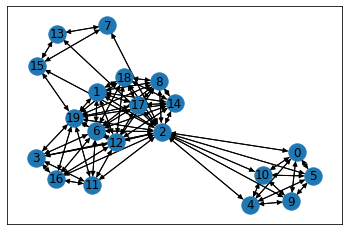

In [20]:
g = pickle.loads( eval(df["dgl_graph"].iloc[0]))
# convert dgl graph to networkx graph
g_nx = g.to_networkx()
nx.draw_networkx(g_nx)

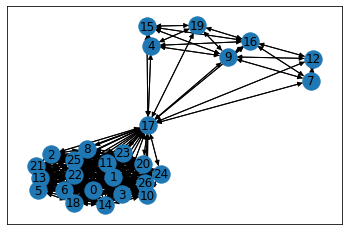

In [16]:
g = pickle.loads( eval(df["dgl_graph"].iloc[100]))
g_nx = g.to_networkx()
nx.draw_networkx(g_nx)

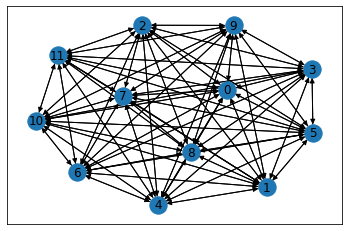

In [17]:
g = pickle.loads( eval(df["dgl_graph"].iloc[500]))
g_nx = g.to_networkx()
nx.draw_networkx(g_nx)

## DRUM Fit

In [22]:
%%sh
mkdir -p custom-training/custom-task-gin-fit &&
drum fit --code-dir /content/custom-training/custom-task-gin --target-type binary --target labels --input custom-training/graph2.csv --output custom-training/custom-task-gin-fit


Success 🎉


Using backend: pytorch
Epoch 0 | Loss: 10.5301
Epoch 100 | Loss: 0.5254
Epoch 200 | Loss: 0.5141
Epoch 300 | Loss: 0.5115
Epoch 400 | Loss: 0.5093
2021-07-21 01:14:58,010 WARNING drum:  
                            The last 10 predictions from the main predict run were:         1         0
 0.129716  0.870284
 0.129716  0.870284
 0.300047  0.699953
 0.300047  0.699953
 0.125791  0.874209
 0.948393  0.051607
 0.948393  0.051607
 0.642611  0.357389
 0.642611  0.357389
 0.129717  0.870283
                            However when we reran predictions on the same data, we got:         1         0
 0.174380  0.825620
 0.174380  0.825620
 0.416567  0.583433
 0.416567  0.583433
 0.142613  0.857387
 0.909570  0.090430
 0.909570  0.090430
 0.927509  0.072491
 0.927509  0.072491
 0.174380  0.825620.
                            The sample used to calculate prediction reruns can be found in this file: /tmp/tmpe91e9yf9.csv


## DRUM Score

In [30]:
%%sh
drum score --code-dir custom-training/custom-task-gin-fit --input custom-training/graph2.csv --positive-class-label 1 --negative-class-label 0 --target-type binary

            0         1
0    0.514341  0.485659
1    0.721728  0.278272
2    0.552220  0.447780
3    0.585978  0.414022
4    0.562124  0.437876
..        ...       ...
995  0.604291  0.395709
996  0.417596  0.582404
997  0.004219  0.995781
998  0.083235  0.916765
999  0.094613  0.905387

[1000 rows x 2 columns]


Using backend: pytorch


In [32]:
print("https://app.datarobot.com/projects/60f5d1af861844cd4539bb8e/eda")

https://app.datarobot.com/projects/60f5d1af861844cd4539bb8e/eda
